In [47]:
# I love Google Colab
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/

In [48]:
# Some important point that you should not miss
# Mouting data with google drive is not good beacuse it take more time to fetch image one by one from google drive
# Uploading data in Google colab is more time effcient may be because it is putting data in its cache
# Uploaded data get delete after changing run time
# Select GPU first and then upload data otherwise if you change runtime after uploading data, data will be get deleted
# While uploading data colab will say "Warning: you are connected to a GPU runtime, but not utilizing the GPU. " and give you option to change runtime.But never change runtime otherwise  data will be get deleted
# How to prevent Google Colab from disconnecting?
# => https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting

In [49]:
#check info of alloted GPU
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.callbacks import ModelCheckpoint
print("=====>",tf.test.gpu_device_name())
# how much gpu is avalable to you by seeing last line
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()
# print("========================================")

=====> /device:GPU:0


In [ ]:
#get the data
%ls
!rm -rf data
%ls
!unzip data.zip

In [51]:
# shared function between age group and gender prediction

# Take one fold x it will return formatted numpy data
def create_training_data(x):
	l=[]
	text_file_name="./data/fold_"+str(x)+"_data.txt"
	text_file = open(text_file_name, "r")
	lines = text_file.readlines()
	for line in lines:
		ls=line.split("\t")
		file_name="./data/faces/"+ls[0]+'/coarse_tilt_aligned_face.'+ls[2]+"."+ls[1]
		temp=ls[3].replace(" ","")[1:-1].split(",")
		valid_age=-1
		# 0-2, 4-6, 8-13, 15-20, 25-32, 38-43, 48-53, 60-
		l_Age_1=[0,4,8,15,25,38,48,60]
		l_Age_2=[2,6,13,20,32,43,53,100]
		for i in range(8):
			if ls[3].isdigit() and (int(ls[3])>=l_Age_1[i] and int(ls[3])<=l_Age_2[i]):
				valid_age=i
			elif temp[0].isdigit() and l_Age_1[i]==int(temp[0]):
				valid_age=i
			elif (temp[0].isdigit() and temp[1].isdigit()):
				avg=(int(temp[0])+int(temp[1]))/2.0
				if(avg>=l_Age_1[i] and avg<=l_Age_2[i]):
					valid_age=i

		valid_gender=-1
		valid2=["m","f","u"]
		for i in range(len(valid2)):
			if valid2[i]==ls[4]:
				valid_gender=i

		img = cv2.imread(file_name)
		
		if valid_gender!=-1 and valid_age!=-1 and (img is not None) and img.shape[0]==227 and img.shape[1]==227:
			img=np.array(img)
			l.append([np.array(img),valid_gender,valid_age])

	text_file.close()
	return l

def get_exact1off_acc(test_X,test_Y,Model):
  result = Model.predict_classes(test_X)
  correctly_classified=0
  for i in range(len(result)):
    if(abs(result[i]-test_Y[i])==1 or abs(result[i]-test_Y[i])==0):
      correctly_classified+=1
  return ((correctly_classified/len(result))*100)

#plot accuracy and loss
def plot(history):
	# print(history.history)
	#accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
  #loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
 
#As the name suggest
def run_save_plot_test_model(Model,name,epoch,train_X,train_Y,valid_X,valid_Y,test_X,test_Y):
  # checkpoint
	filepath=name+"_weights.best.h5"
	checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
	callbacks_list = [checkpoint]
  #run the model
	history = Model.fit(train_X, train_Y, epochs=epoch,validation_data=(valid_X, valid_Y),callbacks=callbacks_list)
  #load the weights in model
	Model.load_weights(name+"_weights.best.h5")
  #plot the model
	plot(history)
  #real testing of model
	test_loss, test_acc = Model.evaluate(test_X,  test_Y, verbose=2)
	print("\n\nAccuracy(",name,") on Test images ==> ",test_acc*100,"% \n")
	print("\n\nExact 1-off Accuracy(",name,") on Test images ==> ",get_exact1off_acc(test_X,test_Y,Model),"% \n")

In [60]:
model_age = models.Sequential()
#CONV1
model_age.add(layers.Conv2D(96, (7, 7),strides=(4,4), input_shape=(227, 227, 3)))
model_age.add(layers.Activation('relu'))
model_age.add(layers.BatchNormalization())
model_age.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_age.add(layers.Dropout(0.6))
#CONV2
model_age.add(layers.Conv2D(256, (5, 5)))
model_age.add(layers.Activation('relu'))
model_age.add(layers.BatchNormalization())
model_age.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_age.add(layers.Dropout(0.6))
#CONV3
model_age.add(layers.Conv2D(384, (3, 3)))
model_age.add(layers.Activation('relu'))
model_age.add(layers.BatchNormalization())
model_age.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_age.add(layers.Dropout(0.6))
#CONV4
model_age.add(layers.Conv2D(256, (3, 3)))
model_age.add(layers.Activation('relu'))
model_age.add(layers.BatchNormalization())
model_age.add(layers.MaxPooling2D(pool_size=(3, 3)))
model_age.add(layers.Dropout(0.6))
#flat
model_age.add(layers.Flatten())
# FC1
model_age.add(layers.Dense(512))
model_age.add(layers.Activation('relu'))
model_age.add(layers.BatchNormalization())
model_age.add(layers.Dropout(0.6))
#FC2
model_age.add(layers.Dense(8))
model_age.add(layers.Activation('softmax'))

model_age.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_age.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 56, 56, 96)        14208     
_________________________________________________________________
activation_68 (Activation)   (None, 56, 56, 96)        0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 56, 56, 96)        384       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 28, 28, 96)        0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 24, 24, 256)       614656    
_________________________________________________________________
activation_69 (Activation)   (None, 24, 24, 256)     

In [58]:
model_gender = models.Sequential()
#CONV1
model_gender.add(layers.Conv2D(96, (7, 7),strides=(4,4), input_shape=(227, 227, 3)))
model_gender.add(layers.Activation('relu'))
model_gender.add(layers.BatchNormalization())
model_gender.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_gender.add(layers.Dropout(0.6))
#CONV2
model_gender.add(layers.Conv2D(256, (5, 5)))
model_gender.add(layers.Activation('relu'))
model_gender.add(layers.BatchNormalization())
model_gender.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_gender.add(layers.Dropout(0.6))
#CONV3
model_gender.add(layers.Conv2D(384, (3, 3)))
model_gender.add(layers.Activation('relu'))
model_gender.add(layers.BatchNormalization())
model_gender.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_gender.add(layers.Dropout(0.6))
#CONV4
model_gender.add(layers.Conv2D(256, (3, 3)))
model_gender.add(layers.Activation('relu'))
model_gender.add(layers.BatchNormalization())
model_gender.add(layers.MaxPooling2D(pool_size=(3, 3)))
model_gender.add(layers.Dropout(0.6))
#flat
model_gender.add(layers.Flatten())
# FC1
model_gender.add(layers.Dense(512))
model_gender.add(layers.Activation('relu'))
model_gender.add(layers.BatchNormalization())
model_gender.add(layers.Dropout(0.6))
#FC2
model_gender.add(layers.Dense(3))
model_gender.add(layers.Activation('softmax'))

model_gender.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_gender.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 56, 56, 96)        14208     
_________________________________________________________________
activation_62 (Activation)   (None, 56, 56, 96)        0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 56, 56, 96)        384       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 28, 28, 96)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 24, 24, 256)       614656    
_________________________________________________________________
activation_63 (Activation)   (None, 24, 24, 256)     

In [54]:
# format and split data in training,validation and testing data for age and gender
valid_X = []
valid_Y_gender = []
valid_Y_age = []
train_X = []
train_Y_gender = []
train_Y_age = []
test_X=[]
test_Y_gender=[]
test_Y_age=[]

temp=[]
for fold_id in [0,1,2,3]:
	print("processing ... ",fold_id)
	temp.extend(create_training_data(fold_id))

temp=np.array(temp)
np.random.shuffle(temp)

for i in temp:
	train_X.append(i[0])
	train_Y_gender.append(i[1])
	train_Y_age.append(i[2])

print("processing ...  4")
temp=create_training_data(4)
temp=np.array(temp)
np.random.shuffle(temp)

for i in temp[:int(len(temp)*(0.5))]:
	valid_X.append(i[0])
	valid_Y_gender.append(i[1])
	valid_Y_age.append(i[2])


for i in temp[int(len(temp)*(0.5)):]:
	test_X.append(i[0])
	test_Y_gender.append(i[1])
	test_Y_age.append(i[2])

train_X=np.array(train_X)
train_Y_age=np.array(train_Y_age)
train_Y_gender=np.array(train_Y_gender)

valid_X=np.array(valid_X)
valid_Y_age=np.array(valid_Y_age)
valid_Y_gender=np.array(valid_Y_gender) 

test_X=np.array(test_X)
test_Y_age=np.array(test_Y_age)
test_Y_gender=np.array(test_Y_gender)

print("======================================================")
print("Dimension of training dataset => ",train_X.shape)
print("Dimension of validation dataset => ",valid_X.shape)
print("Dimension of testing dataset => ",test_X.shape)
print("======================================================")
# print(train_X)
# train_X/=255
#Your session crashed after using all available RAM.

processing ...  0
processing ...  1
processing ...  2
processing ...  3
processing ...  4
Dimension of training dataset =>  (12969, 227, 227, 3)
Dimension of validation dataset =>  (1651, 227, 227, 3)
Dimension of testing dataset =>  (1651, 227, 227, 3)


Epoch 1/100
405/406 [============================>.] - ETA: 0s - loss: 0.5908 - accuracy: 0.9642
Epoch 00001: val_accuracy improved from -inf to 0.79467, saving model to Gender_Prediction_weights.best.h5
406/406 [==============================] - 6s 15ms/step - loss: 0.5908 - accuracy: 0.9642 - val_loss: 0.7495 - val_accuracy: 0.7947
Epoch 2/100
405/406 [============================>.] - ETA: 0s - loss: 0.5893 - accuracy: 0.9628
Epoch 00002: val_accuracy improved from 0.79467 to 0.80376, saving model to Gender_Prediction_weights.best.h5
406/406 [==============================] - 6s 15ms/step - loss: 0.5894 - accuracy: 0.9628 - val_loss: 0.7421 - val_accuracy: 0.8038
Epoch 3/100
404/406 [============================>.] - ETA: 0s - loss: 0.5876 - accuracy: 0.9636
Epoch 00003: val_accuracy did not improve from 0.80376
406/406 [==============================] - 6s 15ms/step - loss: 0.5876 - accuracy: 0.9636 - val_loss: 0.7431 - val_accuracy: 0.8025
Epoch 4/100
404/406 [====================

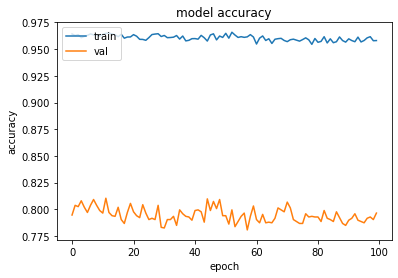

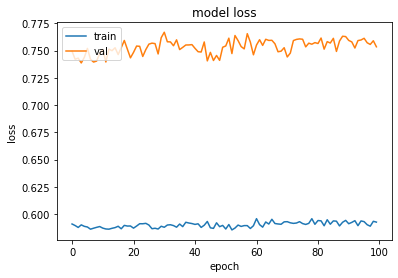

52/52 - 0s - loss: 0.7464 - accuracy: 0.8007


Accuracy( Gender_Prediction ) on Test images ==>  80.072683095932 % 



Exact 1-off Accuracy( Gender_Prediction ) on Test images ==>  97.94064203513022 % 



In [59]:
model_gender.load_weights("Gender_Prediction_weights.best.h5")
run_save_plot_test_model(model_gender,'Gender_Prediction',100,train_X,train_Y_gender,valid_X,valid_Y_gender,test_X,test_Y_gender)

Epoch 1/100
405/406 [============================>.] - ETA: 0s - loss: 1.4057 - accuracy: 0.8864
Epoch 00001: val_accuracy improved from -inf to 0.51423, saving model to Age_Prediction_weights.best.h5
406/406 [==============================] - 6s 16ms/step - loss: 1.4056 - accuracy: 0.8865 - val_loss: 1.7620 - val_accuracy: 0.5142
Epoch 2/100
405/406 [============================>.] - ETA: 0s - loss: 1.3907 - accuracy: 0.8916
Epoch 00002: val_accuracy did not improve from 0.51423
406/406 [==============================] - 6s 15ms/step - loss: 1.3906 - accuracy: 0.8917 - val_loss: 1.7633 - val_accuracy: 0.5027
Epoch 3/100
404/406 [============================>.] - ETA: 0s - loss: 1.3909 - accuracy: 0.8895
Epoch 00003: val_accuracy did not improve from 0.51423
406/406 [==============================] - 6s 15ms/step - loss: 1.3911 - accuracy: 0.8894 - val_loss: 1.7626 - val_accuracy: 0.5082
Epoch 4/100
403/406 [============================>.] - ETA: 0s - loss: 1.3934 - accuracy: 0.8858
Ep

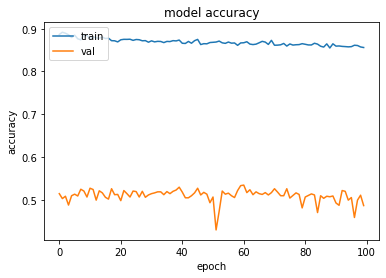

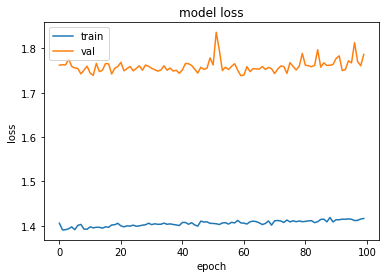

52/52 - 0s - loss: 1.7556 - accuracy: 0.5148


Accuracy( Age_Prediction ) on Test images ==>  51.48394703865051 % 



Exact 1-off Accuracy( Age_Prediction ) on Test images ==>  83.76741368867353 % 



In [61]:
model_age.load_weights("Age_Prediction_weights.best.h5")
run_save_plot_test_model(model_age,'Age_Prediction',100,train_X,train_Y_age,valid_X,valid_Y_age,test_X,test_Y_age)